In [1]:
# Install the required modules
!pip install transformers
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install sklearn

from google.colab import drive
drive.mount('/content/gdrive')

# !nvidia-smi

     |████████████████████████████████| 368kB 4.8MB/s 
     |████████████████████████████████| 645kB 63.5MB/s 
     |████████████████████████████████| 1.0MB 61.6MB/s 
     |████████████████████████████████| 860kB 52.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=f09f17cbabd9dd9d1ffdcc3724d15e4d6939111880eb3d4918b70ba2d89c9600
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your 

In [2]:
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import *

In [0]:
# Embeddings can be derived from the last 1 or 4 layers, to reduce the computational cost, we used only the last layer.

class Embeddings:
    LAST_LAYER = 1
    LAST_4_LAYERS = 2
    def __init__(self):
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self._bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self._bert_model.eval()

    def tokenize(self, sentence):
        """

        :param sentence: input sentence ['str']
        :return: tokenized sentence based on word piece model ['List']
        """
        marked_sentence = "[CLS] " + sentence + " [SEP]"
        tokenized_text = self._tokenizer.tokenize(marked_sentence)
        return tokenized_text

    def get_bert_embeddings(self, sentence):
        """

        :param sentence: input sentence ['str']
        :return: BERT pre-trained hidden states (list of torch tensors) ['List']
        """
        # Predict hidden states features for each layer

        tokenized_text = self.tokenize(sentence)
        indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)

        segments_ids = [1] * len(tokenized_text)

        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        with torch.no_grad():
            encoded_layers = self._bert_model(tokens_tensor, segments_tensors)

        return encoded_layers[-1][0:12]

    def sentence2vec(self, sentence, layers):
        """

        :param sentence: input sentence ['str']
        :param layers: parameter to decide how word embeddings are obtained ['str]
            1. 'last' : last hidden state used to obtain word embeddings for sentence tokens
            2. 'last_4' : last 4 hidden states used to obtain word embeddings for sentence tokens

        :return: sentence vector [List]
        """
        encoded_layers = self.get_bert_embeddings(sentence)
        
        if layers == 1:
            # using the last layer embeddings
            token_embeddings = encoded_layers[-1]
            # summing the last layer vectors for each token
            sentence_embedding = torch.mean(token_embeddings, 1)
            return sentence_embedding.view(-1).tolist()

        elif layers == 2:
            token_embeddings = []
            tokenized_text = self.tokenize(sentence)

            batch_i = 0
            # For each token in the sentence...
            for token_i in range(len(tokenized_text)):

                # Holds 12 layers of hidden states for each token
                hidden_layers = []

                # For each of the 12 layers...
                for layer_i in range(len(encoded_layers)):
                    # Lookup the vector for `token_i` in `layer_i`
                    vec = encoded_layers[layer_i][batch_i][token_i]

                    hidden_layers.append(list(vec.numpy()))

                token_embeddings.append(hidden_layers)

            # using the last 4 layer embeddings
            token_vecs_sum = []

            # For each token in the sentence...
            for token in token_embeddings:
                # Sum the vectors from the last four layers.
                sum_vec = np.sum(token[-4:], axis=0)

                # Use `sum_vec` to represent `token`.
                token_vecs_sum.append(list(sum_vec))

            # summing the last layer vectors for each token
            sentence_embedding = np.mean(token_vecs_sum, axis=0)
            return sentence_embedding.ravel().tolist()

In [0]:
# Dataset: 3000 chunks * 3 authors, without masking

url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/Datasets/raw_text_3000.csv'
df = pd.read_csv(url)

X = df.text.astype('str')
y = df.author.astype('category')

# lbl_enc = preprocessing.LabelEncoder()
# y = lbl_enc.fit_transform(y.values)

y = np.asarray(y)
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
encoded = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(encoded)

In [0]:
# Dataset: 3000 chunks * 3 authors, with masking

url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/Datasets/masked_text_3000.csv'
df = pd.read_csv(url)

X = df.text.astype('str')
y = df.author.astype('category')

y = np.asarray(y)
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
encoded = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(encoded)

In [0]:
model = Embeddings()

X_text = []
for sentence in tqdm(X):
    X_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))

In [0]:
# For Test Time

url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/masked_results.csv'
df = pd.read_csv(url).set_index('Unnamed: 0')

X_old = df.old.astype('str')
X_new = df.new.astype('str')

model = Embeddings()

X_old_text, X_new_text = [], []
for sentence in tqdm(X_old):
    X_old_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))
for sentence in tqdm(X_new):
    X_new_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))

In [0]:
# X_old = pd.DataFrame(X_old_text)
# X_old.to_csv('./gdrive/My Drive/DL/Style/X_old_Embedding.csv')

# X_new = pd.DataFrame(X_new_text)
# X_new.to_csv('./gdrive/My Drive/DL/Style/X_new_Embedding.csv')

In [0]:
# X_df = pd.DataFrame(X_text)
# X_df.to_csv('./gdrive/My Drive/DL/Style/DistilBert_Embedding_3000_2.csv')

In [16]:
# For old Rand examples

# url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/rand_examples.csv'
# df = pd.read_csv(url).set_index('Unnamed: 0')


# X1 = df['Rand-donor-text'].astype('str')
# X2 = df['Rand_117M_10000_Nabokov-All-3'].astype('str')
# X3 = df['Rand-output-ngram'].astype('str')

# model = Embeddings()

# X1_text, X2_text, X3_text = [], [], []
# for sentence in tqdm(X1):
#     X1_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))
# for sentence in tqdm(X2):
#     X2_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))
# for sentence in tqdm(X2):
#     X3_text.append(model.sentence2vec(sentence, layers=model.LAST_LAYER))

100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


### Building A Atyle Alassifier on Top of DistilBert Embeddings

In [17]:
# X_df = pd.DataFrame(X_text)
# X_df.to_csv('./gdrive/My Drive/DL/Style/DistilBert_Embedding_3000.csv')

X_df = pd.read_csv('./gdrive/My Drive/DL/Style/DistilBert_Embedding_3000_2.csv').set_index('Unnamed: 0')

X_train, X_val, y_train, y_val = train_test_split(X_df, y, stratify=y, random_state=1, test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1, shuffle=True)

print(X_train.shape, X_val.shape)

(7200, 768) (900, 768)


In [0]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5614,-0.340161,-0.148656,0.602034,-0.272003,-0.341873,-0.120357,0.224259,0.206777,-0.050708,-0.413362,0.106826,-0.422804,-0.132413,0.146387,-0.105816,0.753637,0.414343,0.122540,0.179269,0.088668,0.793956,-0.148916,0.095241,0.706351,0.180122,0.449534,0.147201,-0.237596,-0.151617,-0.037453,0.579897,0.074145,0.068724,-0.265257,-0.118240,-0.280390,0.099969,-0.501312,0.068412,0.072087,...,-0.236783,-0.722360,-0.142746,-0.070288,-0.142651,-0.857589,-0.207489,0.172034,-0.133808,-0.344236,-0.061278,0.064547,0.122214,-0.097235,0.183206,-0.092817,-0.457735,0.098827,-0.223504,0.734053,-0.446106,0.604875,0.058997,-0.558629,-0.211270,-0.087967,-0.125183,-0.588484,-0.453498,-0.176318,-0.628320,0.045665,0.183669,-0.280129,-0.195073,-0.313454,-0.230915,-0.017511,0.452152,0.481604
2383,-0.391934,0.589659,0.081654,-0.364856,0.272116,-0.185212,-0.179081,0.248599,-0.116149,-0.085957,0.279195,-0.495050,-0.024453,0.470089,0.149684,1.075918,0.142027,-0.185910,0.287008,0.135054,0.798489,-0.099341,0.331279,0.542002,0.268069,0.279488,0.068858,-0.253427,-0.456926,0.170671,0.415524,-0.215536,-0.112373,-0.604337,0.137619,-0.606019,0.378203,-0.173980,0.747436,0.213383,...,-0.194351,-0.251167,-0.103786,-0.614198,-0.427270,-0.536838,-0.142121,0.175018,0.257659,0.063984,0.204867,0.264982,0.090459,-0.156936,0.328172,-0.267422,0.004332,0.437211,0.271880,0.837500,-0.222474,0.509900,-0.052957,-0.122060,0.306961,0.155461,0.102520,-0.191638,-0.222842,-0.347603,-0.569109,0.100797,-0.224095,0.094102,0.375749,0.166803,-0.509638,0.045654,0.267326,0.322551
5448,-0.311391,0.246223,0.322206,-0.626673,-0.120535,-0.328576,0.340233,0.150335,-0.228633,-0.119519,0.234018,-0.455078,0.094305,0.039104,-0.354940,1.053825,0.437839,0.352679,0.163303,-0.222175,0.575262,-0.151778,0.039601,0.237160,0.136593,0.441844,0.216453,-0.411612,-0.499689,-0.125523,0.927454,-0.064041,0.280551,0.071708,-0.018094,-0.288303,0.428391,-0.406295,0.066329,0.261219,...,-0.063150,-0.204630,-0.137450,-0.170344,-0.314548,-0.759352,-0.347153,-0.266005,-0.034147,0.089698,-0.136013,0.242091,0.530148,-0.121507,0.408584,-0.177793,-0.448586,-0.175234,0.130837,0.919979,-0.481680,0.259219,0.216071,-0.403066,-0.032478,0.047672,0.106018,-0.227465,-0.409935,-0.288559,-0.625146,0.146311,0.043609,0.026973,0.094333,-0.698623,-0.382027,-0.658689,0.190388,0.197619
8412,-0.157567,0.439942,0.159633,-0.716131,0.394165,-0.170059,0.290004,0.776767,-0.385152,-0.022196,0.137164,-0.146209,0.309307,-0.086701,-0.312970,0.535559,0.378450,0.155951,0.159643,-0.078866,0.229330,-0.042130,-0.046688,0.110598,-0.052326,0.334858,0.294528,0.001301,-0.752542,0.043778,0.562868,0.093217,-0.056954,-0.345783,-0.071456,-0.615525,0.299450,-0.361907,0.153372,0.102023,...,-0.160457,-0.595206,-0.231311,-0.040880,0.016651,-0.327501,-0.104689,-0.158801,-0.196048,0.014901,-0.336172,-0.002332,0.202591,-0.242723,0.059663,-0.198993,0.126893,0.143854,0.008069,0.378277,-0.390169,0.389232,0.494898,-0.393445,0.279485,0.022502,0.140657,0.021231,-0.466449,0.030109,-0.550439,0.104452,-0.086756,-0.266146,0.756947,-0.396499,-0.247555,-0.413154,0.299626,0.228981
1448,-0.166418,0.318898,0.330421,-0.459612,-0.162131,0.267957,0.236269,0.415457,-0.052450,-0.242916,0.365095,-0.367487,-0.144583,0.366747,-0.179655,0.657255,0.487739,0.288062,-0.025196,-0.025123,1.028283,0.087602,0.023006,0.461438,0.195829,0.166410,-0.029758,-0.221556,-0.417432,0.024154,0.216279,-0.060858,0.727997,-0.428053,0.269999,-0.264617,0.174458,-0.049764,0.479403,0.235735,...,0.167074,-0.798584,-0.346666,-0.463683,-0.125071,-0.276027,-0.208865,0.138834,-0.086230,-0.017895,-0.248692,0.168226,0.456018,-0.261686,0.062923,-0.336427,-0.276823,0.119

In [0]:
# Feed-Forward Neural Nets
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        """The forward pass of the FFNN
        
        Args:
            x (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        c = self.fc1(x)
        x = self.bn1(c)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        c = torch.cat((x, c), 1)
        x = self.fc2(c)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)
        c = torch.cat((x, c), 1)
        x = self.fc3(c)
        x = self.bn3(x)
        x = F.relu(x)
        output = F.dropout(x, p=0.5)
     
        return output

batch_size = 32 # number of samples input at once
input_dim = 768
hidden_dim = 128
output_dim = 3

# Initialize model
model = FFNN(input_dim, hidden_dim, output_dim)
print(model)

X = torch.tensor(np.array(X_train))
# y_output = model(X)
# describe(y_output)

FFNN(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (bn3): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [19]:
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, LSTM, Dense, Input, Dropout, GRU, Conv1D, MaxPooling1D, BatchNormalization, Activation, concatenate
from keras.layers import Bidirectional, Flatten, RepeatVector, Permute, Multiply, Lambda, TimeDistributed
from keras import backend as K

from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [20]:
# TBA: Hyperpameter Tuning Through lr, units & batch; TensorBoard for training process and/or model structure?

units = 1024
lr = 0.0005
patience = 5
batch = 32


inputs = Input(shape=(768,), dtype='float32')
c = Dense(units)(inputs)
x = BatchNormalization()(c)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
c = concatenate([x, c])

def FFUnit(c):
  x = Dense(units)(c)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  c = concatenate([x, c])
  return c

for i in range(6):
  c = FFUnit(c)

x = Dense(3)(c)
x = BatchNormalization()(x)
outputs = Activation('softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer=Adam(lr=lr),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train,
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=patience, 
          batch_size=batch)

cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=patience,
                   restore_best_weights=True)

model.compile(optimizer=Adam(lr=lr/3),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train, 
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=99, 
          batch_size=batch,
          callbacks=[cb])

model.compile(optimizer=Adam(lr=lr/6),
              loss="categorical_crossentropy",
              metrics=["acc"])

model.fit(x=X_train, 
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=99, 
          batch_size=batch,
          callbacks=[cb])


print('===Evaluation===')
model.evaluate(X_test, y_test)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         787456      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024)         4096        dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024)         0           batch_n

[0.059320129950841266, 0.9822222222222222]

In [0]:
X_old_text = pd.DataFrame(X_old_text)
X_new_text = pd.DataFrame(X_new_text)

Pred_old = model.predict(X_old_text)
Pred_new = model.predict(X_new_text)

# X1_text = pd.DataFrame(X1_text)
# X2_text = pd.DataFrame(X2_text)
# X3_text = pd.DataFrame(X3_text)

# Pred1 = model.predict(X1_text)[:, 2]
# Pred2 = model.predict(X2_text)[:, 2]
# Pred3 = model.predict(X3_text)[:, 2]

In [0]:
# df['Rand_donor_style'] = Pred1
# df['Rand_117M_10000_Nabokov_All_3_style'] = Pred2
# df['Rand_unigram_style'] = Pred3
# df.to_csv('./gdrive/My Drive/DL/Style/rand_examples.csv')

In [0]:
url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/masked_results.csv'
df = pd.read_csv(url).set_index('Unnamed: 0')

pred_old, pred_new, pred_delta = [], [], []
for i in range(len(X_old)): 
  if df.label.iloc[i][2] == 'A':
    pred_old.append(Pred_old[i][0])
    pred_new.append(Pred_new[i][0])
  elif df.label.iloc[i][2] == 'D':
    pred_old.append(Pred_old[i][1])
    pred_new.append(Pred_new[i][1])
  else:
    pred_old.append(Pred_old[i][2])
    pred_new.append(Pred_new[i][2])
  pred_delta.append(pred_new[i] - pred_old[i])

In [0]:
Pred_new

array([[0.00203248, 0.00404928, 0.9939182 ],
       [0.00727922, 0.00358726, 0.98913354],
       [0.7721936 , 0.0139337 , 0.2138727 ],
       [0.00891649, 0.00448649, 0.986597  ],
       [0.1125346 , 0.00660644, 0.8808589 ],
       [0.00478178, 0.12722215, 0.86799604],
       [0.00129496, 0.00179181, 0.9969132 ],
       [0.9057036 , 0.0124633 , 0.08183308],
       [0.0044654 , 0.01962554, 0.97590905],
       [0.01275224, 0.37084013, 0.61640763],
       [0.00131232, 0.00184203, 0.99684566],
       [0.00157802, 0.00203662, 0.99638534],
       [0.06523793, 0.00728321, 0.9274789 ],
       [0.0049958 , 0.01522104, 0.97978324],
       [0.00574131, 0.00443773, 0.98982096],
       [0.00687255, 0.39102003, 0.60210735],
       [0.00370327, 0.02648717, 0.96980953],
       [0.4538185 , 0.5200149 , 0.02616665],
       [0.00597845, 0.89414316, 0.09987843],
       [0.00557098, 0.21227232, 0.7821567 ],
       [0.00246911, 0.00275852, 0.9947724 ],
       [0.0138345 , 0.00573398, 0.9804315 ],
       [0.

In [0]:
Pred_old

array([[1.3854805e-03, 1.4774617e-03, 9.9713707e-01],
       [1.0117523e-03, 1.3248584e-03, 9.9766338e-01],
       [2.9079651e-03, 2.2302193e-03, 9.9486178e-01],
       [1.4082204e-03, 1.8278309e-03, 9.9676394e-01],
       [1.6231856e-03, 1.9362279e-03, 9.9644059e-01],
       [1.2254277e-03, 1.7493755e-03, 9.9702519e-01],
       [1.1799920e-03, 1.4283181e-03, 9.9739170e-01],
       [3.5569761e-02, 9.7493092e-03, 9.5468098e-01],
       [3.1336043e-03, 7.9622054e-03, 9.8890418e-01],
       [1.7892765e-03, 2.5100240e-03, 9.9570066e-01],
       [1.3854805e-03, 1.4774617e-03, 9.9713707e-01],
       [1.0117523e-03, 1.3248584e-03, 9.9766338e-01],
       [2.9079651e-03, 2.2302193e-03, 9.9486178e-01],
       [1.4082204e-03, 1.8278309e-03, 9.9676394e-01],
       [1.6231856e-03, 1.9362279e-03, 9.9644059e-01],
       [1.2254277e-03, 1.7493755e-03, 9.9702519e-01],
       [1.1799920e-03, 1.4283181e-03, 9.9739170e-01],
       [3.5569761e-02, 9.7493092e-03, 9.5468098e-01],
       [3.1336043e-03, 7.962

In [0]:
pred_delta

[0.0006469997,
 0.0062674712,
 0.7692856,
 0.0075082732,
 0.11091142,
 0.0035563535,
 0.0001149649,
 0.8701338,
 0.0013317978,
 0.010962961,
 0.0003645725,
 0.0007117655,
 0.005052993,
 0.013393214,
 0.0025015022,
 0.38927066,
 0.025058856,
 0.5102656,
 0.88618094,
 0.20976229,
 0.0006734743,
 0.0038146484,
 -0.00038100418,
 -0.00039460126,
 0.013222156,
 0.0006942038,
 0.0022851413,
 0.0036058815,
 0.009100723,
 0.18217164,
 0.0068443003,
 0.02285327,
 0.64718056,
 -0.00032561668,
 0.024243161,
 0.841374,
 0.004301003,
 0.00018604274,
 0.92801166,
 0.2587181,
 0.36065552,
 0.2392447,
 0.010925005,
 0.11558467,
 0.10364332,
 0.0069973934,
 0.0052578673,
 0.0022290314,
 0.00016624876,
 0.002378278,
 0.1277139,
 0.012937957,
 0.1438997,
 -0.0009582578,
 0.05848083]

In [0]:
url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/arrow_plot_results.csv'
df = pd.read_csv(url)
df['donor_authorship_score'] = pred_old
df['style_authorship_score'] = pred_new
df['authorship_delta'] = pred_delta

In [0]:
# df.to_csv('./gdrive/My Drive/DL/Style/all_scores.csv')

In [0]:
# For old examples



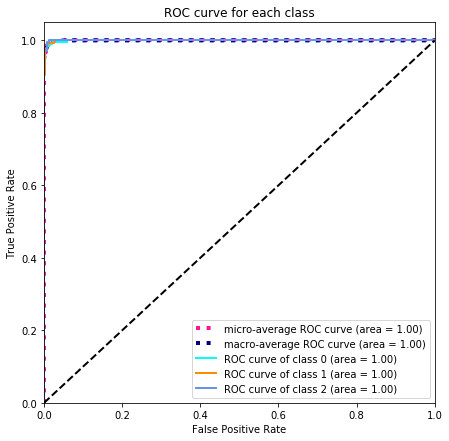

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

import matplotlib.pyplot as plt
%matplotlib inline

pred = model.predict(X_test)

# Binarize the multiclass labels
Y_bi = label_binarize(y, classes=['Austen', 'Dumas', 'Nabokov'])
n_classes = Y_bi.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each class')
plt.legend(loc="lower right")
plt.show()

In [0]:
url = 'https://raw.githubusercontent.com/fy164251/text_style_transfer/master/outputs/all_scores.csv'
df = pd.read_csv(url).set_index('Unnamed: 0')
df

,old,new,old_masked,new_masked,label,donor_naturalness_score,style_naturalness_score,naturalness_delta,donor_authorship_score,style_authorship_score,authorship_delta
Unnamed: 0,,,,,,,,,,,
0,"stepped back a bit, as if admiring it, and hi...","stepped back a bit, to look at it, and his fem...","stepped back a bit, as if admiring it, and hi...","stepped back a bit, to look at it, and his fe...",N2A,0.990052,0.987915,0.002137,0.001385,0.002032,0.000647
1,Pal Palych! How’re they biting?” He looked up...,Pal Palych! How ’ re they biting? ” He looked ...,Pal Palych! How ’ re they biting? ” He looked...,Pal Palych! How ’ re they biting? ” He looked...,N2A,0.960177,0.992160,-0.031982,0.001012,0.007279,0.006267
2,but at least it revealed a small balcony one ...,but at least it revealed a small balcony above...,but at least it revealed a small balcony one ...,but at least it revealed a small balcony abov...,N2A,0.986264,0.994932,-0.008668,0.002908,0.772194,0.769286
3,"had not been placed together, told the waiter...","had not been placed together, told the waiter ...","had not been placed together, told the waiter...","had not been placed together, told the waiter...",N2A,0.959302,0.990870,-0.031567,0.001408,0.008916,0.007508
4,not a Portrait of Lolita: the differences bet...,not a Portrait of Lolita: the differences betw...,not a Portrait of <MASK>: the differences bet...,not a Portrait of <MASK>: the differences bet...,N2A,0.972211,0.994189,-0.021978,0.001623,0.112535,0.110911
5,"his right, the way Anglo-Saxons do in cartoon...","his right, the way Anglo-Saxons do in cartoons...","his right, the way Anglo-Saxons do in cartoon...","his right, the way Anglo-Saxons do in cartoon...",N2A,0.992910,0.992968,-0.000058,0.001225,0.004782,0.003556
6,"in a gigantic, joyous world. A tall pillar on...","in a gigantic, joyous world. A tall pillar on ...","in a gigantic, joyous world. A tall pillar on...","in a gigantic, joyous world. A tall pillar on...",N2A,0.975876,0.994505,-0.018629,0.001180,0.001295,0.000115
7,traversed by the black bend-let of a branch. ...,traversed by the black bend-let of a branch. A...,traversed by the black bend-let of a branch. ...,traversed by the black bend-let of a branch. ...,N2A,0.897903,0.897903,0.000000,0.035570,0.905704,0.870134
8,cross the frontier. One of the Cabinet Minist...,cross the frontier. One of the Cabinet Ministe...,cross the frontier. One of the Cabinet Minist...,cross the frontier. One of the Cabinet Minist...,N2A,0.967726,0.315845,0.651881,0.003134,0.004465,0.001332


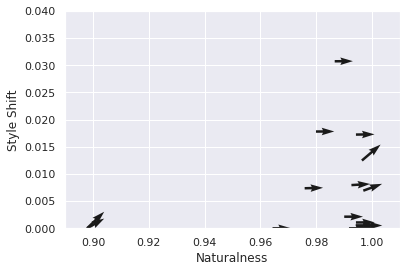

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

x = df['donor_naturalness_score'].values
y = df['style_naturalness_score'].values

u = df['naturalness_delta'].values
v = df['authorship_delta'].values

#plt.axis('equal')
plt.quiver(x,u,y,v)
plt.xlabel('Naturalness')
plt.ylabel('Style Shift')
plt.xlim(left=0.89, right=1.01)
plt.ylim(top=0.04, bottom=0)

plt.show()

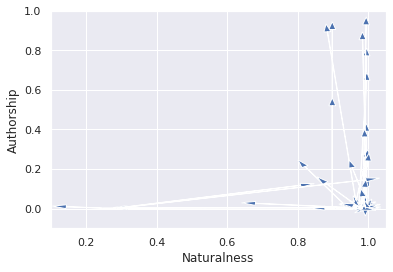

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


x = df['donor_naturalness_score'].values
y = df['donor_authorship_score'].values

u = - df['naturalness_delta'].values
v = df['authorship_delta'].values

Arrows = plt.figure()
for i, j, k, l in zip(x, y, u, v): 
  plt.arrow(i, j, k, l, head_width=0.02, head_length=0.04)
plt.xlabel('Naturalness')
plt.ylabel('Authorship')
plt.xlim(left=0.1, right=1.05)
plt.ylim(top=1, bottom=-0.1)


from google.colab import files

plt.savefig('Arrows.pdf')
files.download('Arrows.pdf')

In [0]:
from google.colab import files
plt.savefig("abc.png")
files.download("abc.png") 

plt.savefig(('./gdrive/My Drive/DL/Style/arrows.pdf'))

<Figure size 432x288 with 0 Axes>